In [1]:
## Multi class classification with Linear SVC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline


Using TensorFlow backend.


In [41]:
## Loading Data :

data_1 = pd.ExcelFile('RNN_Tranzact_Rohan_1_Regrouped_with_supplier.xlsx')
tranzact_data_1 = data_1.parse(0)

tranzact_data_1.head()

,supplier_item_id,to_company_name,supplier_item_id.1,supplier_item_id.2,product,supplier,Done,Atul Sugg.,sub_type,material,process,grade,spec,brand
0,134900,Polfrost Air Con Pvt Ltd.,134900,NEW CYLINDER 404 GAS,GAS,Stallion Enterprises,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18716,Ecofrost Technologies Private Limited,18716,"ACCUMULATOR - MODEL A-AS 5126, (3/4"" CONNECTIO...",COOLING,Neelam Enterprises,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EMERSON
2,19734,Ecofrost Technologies Private Limited,19734,"ACCUMULATOR; FLOKOOL; 3/4""; 400 PSI, FKSA596",COOLING,T J CONTROLS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29713,Polfrost Air Con Pvt Ltd.,29713,ACCUMULATOR 1.5/8 CONNECTION,COOLING,H J International,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39129,Polfrost Air Con Pvt Ltd.,39129,ACCUMULATOR 7/8‘’,COOLING,H J International,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
## Picking up required info :

col = ['to_company_name', 'supplier_item_id.2', 'product', 'supplier']
tranzact_data_2_all = tranzact_data_1[col]
tranzact_data_2_all.columns = ['OEM', 'item', 'product', 'supplier']

print(len(tranzact_data_2_all))

tranzact_data_2_all.tail()

13557


,OEM,item,product,supplier
13552,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE;8"" # 150;GTV; B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
13553,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE 1½"" #2700 BLY;B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
13554,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE;4"" #150 GTV; B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
13555,WAAREE INDUSTRIES PVT. LTD.,"YOKE SLEEVE;8"" # 150;GTV; A439 D2",cicasting,Waaree Industries Pvt.Ltd.
13556,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE; 1"";#1500;CBD;A582 T416",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.


In [52]:
## Removing duplicate features + Supplier combinations :

tranzact_data_2_all['find_duplicate'] = tranzact_data_2_all['item'].map(str)+tranzact_data_2_all['supplier'].map(str)
tranzact_data_2_all.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data_2_all = tranzact_data_2_all.reset_index(drop=True)
print(len(tranzact_data_2_all))


13557


In [53]:
# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd.

tranzact_data_2_cesare_international = tranzact_data_2_all.loc[tranzact_data_2_all['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']

tranzact_data_2 = tranzact_data_2_all.drop(tranzact_data_2_cesare_international.index)

tranzact_data_2_cesare_international = tranzact_data_2_cesare_international.reset_index(drop=True)
tranzact_data_2 = tranzact_data_2.reset_index(drop=True)

print(len(tranzact_data_2_cesare_international))

tranzact_data_2.head()         

1754


,OEM,item,product,supplier,find_duplicate
0,Polfrost Air Con Pvt Ltd.,NEW CYLINDER 404 GAS,GAS,Stallion Enterprises,NEW CYLINDER 404 GASStallion Enterprises
1,Ecofrost Technologies Private Limited,"ACCUMULATOR - MODEL A-AS 5126, (3/4"" CONNECTIO...",COOLING,Neelam Enterprises,"ACCUMULATOR - MODEL A-AS 5126, (3/4"" CONNECTIO..."
2,Ecofrost Technologies Private Limited,"ACCUMULATOR; FLOKOOL; 3/4""; 400 PSI, FKSA596",COOLING,T J CONTROLS,"ACCUMULATOR; FLOKOOL; 3/4""; 400 PSI, FKSA596T ..."
3,Polfrost Air Con Pvt Ltd.,ACCUMULATOR 1.5/8 CONNECTION,COOLING,H J International,ACCUMULATOR 1.5/8 CONNECTIONH J International
4,Polfrost Air Con Pvt Ltd.,ACCUMULATOR 7/8‘’,COOLING,H J International,ACCUMULATOR 7/8‘’H J International


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
## make all in lower case and removing rows with any cell value = none

tranzact_data_2['OEM'] = tranzact_data_2['OEM'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2['item'] = tranzact_data_2['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2['product'] = tranzact_data_2['product'].map(lambda x: x if type(x)!=str else x.lower())

tranzact_data_3 = tranzact_data_2.dropna() ## remove rows with cell value none

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_3.tail()

,OEM,item,product,supplier,find_duplicate
11798,cesare bonetti india pvt. ltd.,"yoke casting 12"" #2500 gtv, sa216 wcc, qap",cs casting,AMI Alloys,"YOKE CASTING 12"" #2500 GTV, SA216 WCC, QAPAMI ..."
11799,cesare bonetti india pvt. ltd.,"yoke cast, 3"" #2500 gtv, sa216 wcc, qap",cs casting,Tulip Casting Pvt. Ltd.,"YOKE CAST, 3"" #2500 GTV, SA216 WCC, QAPTulip C..."
11800,cesare bonetti india pvt. ltd.,"yoke casting 12"" #2500 gtv, sa217 c12a, qap",alloy steel casting,AMI Alloys,"YOKE CASTING 12"" #2500 GTV, SA217 C12A, QAPAMI..."
11801,cesare bonetti india pvt. ltd.,"yoke cast 10"" #150 tcv; a217wc6",alloy steel casting,RAJ ENGINEERS,"YOKE CAST 10"" #150 TCV; A217WC6RAJ ENGINEERS"
11802,waaree industries pvt. ltd.,"yoke sleeve;8"" # 150;gtv; a439 d2",cicasting,Waaree Industries Pvt.Ltd.,"YOKE SLEEVE;8"" # 150;GTV; A439 D2Waaree Indus..."


In [91]:
# digitising 'product' and creating a dictionary :

tranzact_data_3['product_id'] = tranzact_data_3['product'].factorize()[0]

product_id_df = tranzact_data_3[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

pd.options.mode.chained_assignment = None

punctuation = [':', ';', '!'] 

for i in punctuation:
    
    tranzact_data_3['item']= tranzact_data_3['item'].str.replace(i," ")
    
tranzact_data_3.tail()

,OEM,item,product,supplier,find_duplicate,product_id
11798,cesare bonetti india pvt. ltd.,"yoke casting 12"" #2500 gtv, sa216 wcc, qap",cs casting,AMI Alloys,"YOKE CASTING 12"" #2500 GTV, SA216 WCC, QAPAMI ...",18
11799,cesare bonetti india pvt. ltd.,"yoke cast, 3"" #2500 gtv, sa216 wcc, qap",cs casting,Tulip Casting Pvt. Ltd.,"YOKE CAST, 3"" #2500 GTV, SA216 WCC, QAPTulip C...",18
11800,cesare bonetti india pvt. ltd.,"yoke casting 12"" #2500 gtv, sa217 c12a, qap",alloy steel casting,AMI Alloys,"YOKE CASTING 12"" #2500 GTV, SA217 C12A, QAPAMI...",39
11801,cesare bonetti india pvt. ltd.,"yoke cast 10"" #150 tcv a217wc6",alloy steel casting,RAJ ENGINEERS,"YOKE CAST 10"" #150 TCV; A217WC6RAJ ENGINEERS",39
11802,waaree industries pvt. ltd.,"yoke sleeve 8"" # 150 gtv a439 d2",cicasting,Waaree Industries Pvt.Ltd.,"YOKE SLEEVE;8"" # 150;GTV; A439 D2Waaree Indus...",17


In [95]:
tranzact_data_3.info()
print(min(tranzact_data_3['product_id']))
print(max(tranzact_data_3['product_id']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11803 entries, 0 to 11802
Data columns (total 6 columns):
OEM               11803 non-null object
item              11803 non-null object
product           11803 non-null object
supplier          11803 non-null object
find_duplicate    11803 non-null object
product_id        11803 non-null int64
dtypes: int64(1), object(5)
memory usage: 553.3+ KB
0
70


1737


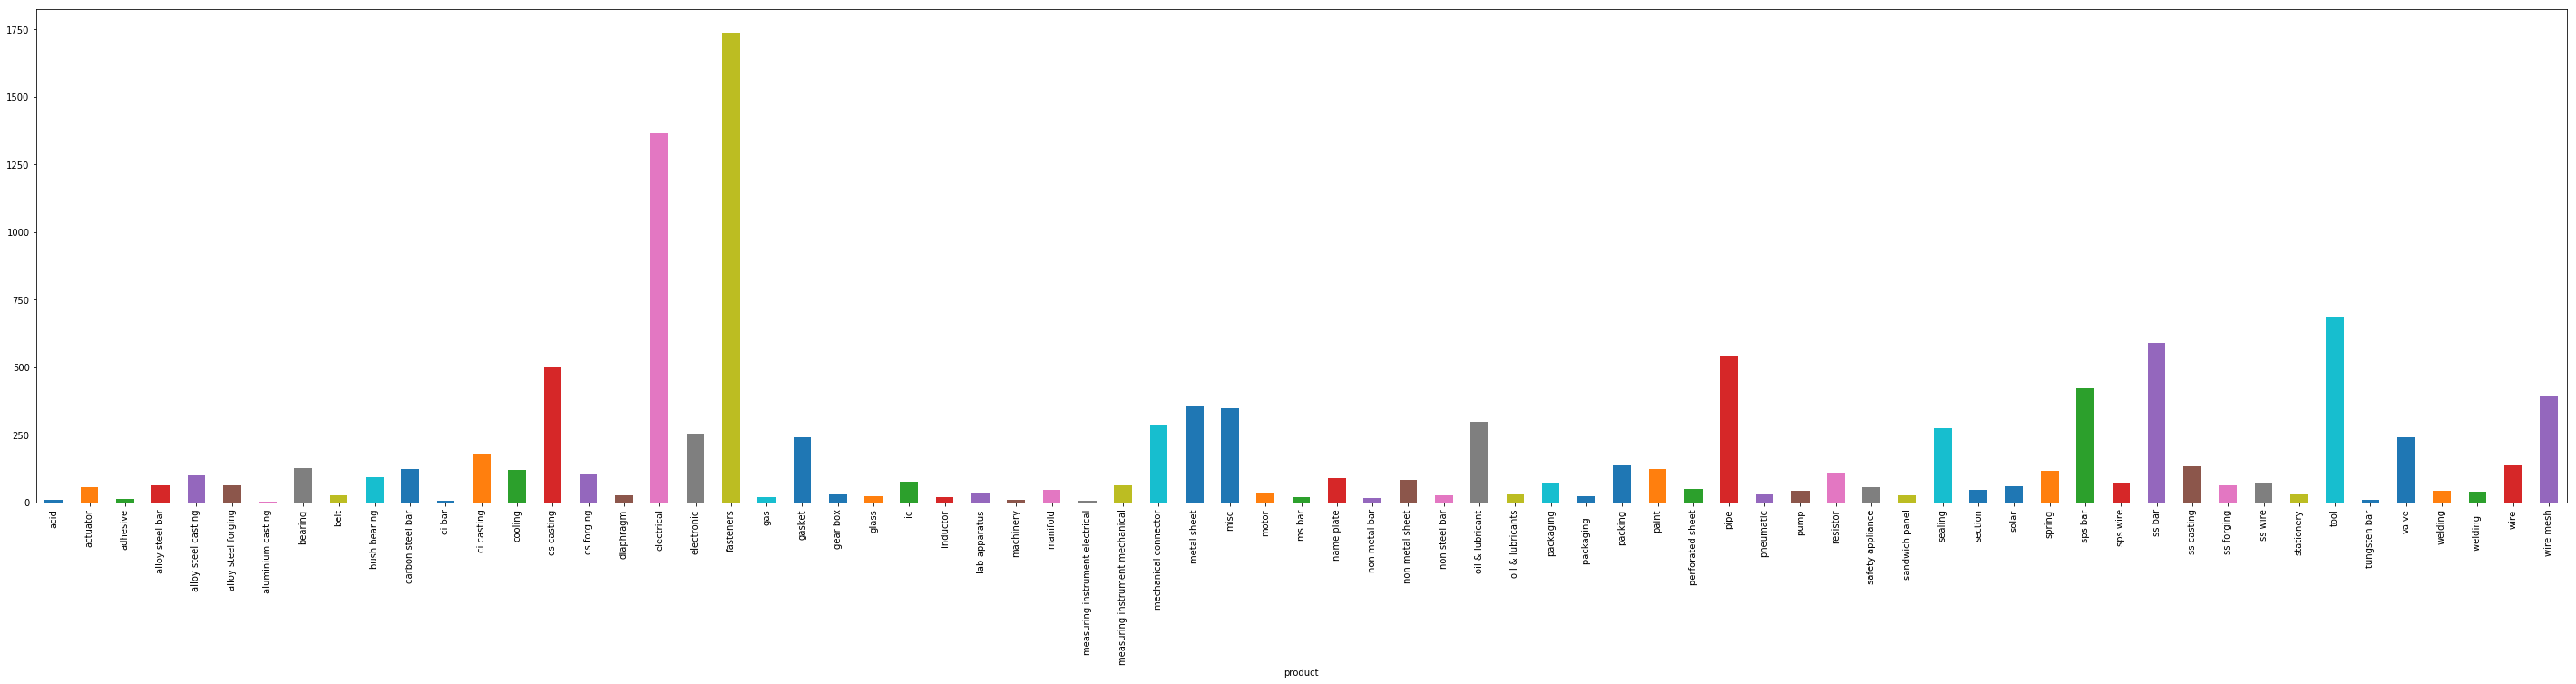

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(50,10))
print(max(tranzact_data_3.groupby('product').item.count()))
tranzact_data_3.groupby('product').item.count().plot.bar(ylim=0)
plt.show()


In [56]:
from collections import Counter
Counter(tranzact_data_3["product"])

Counter({'acid': 9,
         'actuator': 61,
         'adhesive': 12,
         'alloy steel bar': 63,
         'alloy steel casting': 99,
         'alloy steel forging': 62,
         'aluminium casting': 3,
         'bearing': 128,
         'belt': 28,
         'bush bearing': 93,
         'carbon steel bar': 125,
         'ci bar': 5,
         'cicasting': 179,
         'cooling': 130,
         'cs casting': 500,
         'cs forging': 104,
         'diaphragm': 28,
         'electrical': 1362,
         'electronic': 255,
         'fasteners': 1737,
         'gas': 21,
         'gasket': 241,
         'gear box': 30,
         'glass': 22,
         'ic': 78,
         'inductor': 19,
         'lab-apparatus': 33,
         'machinery': 10,
         'manifold': 47,
         'measuring instrument electrical': 6,
         'measuring instrument mechanical': 65,
         'mechanical connector': 289,
         'metal sheet': 358,
         'misc': 350,
         'motor': 38,
         'ms bar': 20

In [21]:
from collections import Counter
Counter(tranzact_data_3["OEM"])

Counter({'accuster technologies pvt ltd': 53,
         'atomberg technologies private limited': 352,
         'caliber enterprises': 10,
         'cesare bonetti (i) pvt. ltd.': 67,
         'cesare bonetti india pvt. ltd.': 2719,
         'chemtrols emet private limited': 46,
         'ecofrost technologies private limited': 1031,
         'ecozen solutions pvt. ltd.  (pune)': 50,
         'ecozen solutions pvt. ltd. (raipur)': 14,
         'enmech systems and solutions': 30,
         'entech controls': 1061,
         'fans bro erectors': 1,
         'fluorobond industries': 112,
         'general metals & polymers': 2,
         'greenway grameen infra pvt ltd': 103,
         'hendo industries': 1,
         'international wirenetting industries': 324,
         'kris automated packaging systems pvt. ltd.': 3,
         'le electronics pvt ltd': 141,
         'm/s plastech': 1,
         'm/s. chemi plant engineering company': 195,
         'meta-tech portable cabin': 6,
         'meta-te

Text(0.5,1,'Number of product categories')

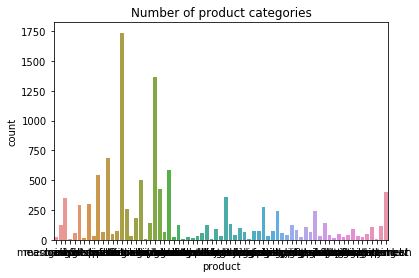

In [9]:
sns.countplot(tranzact_data_3["product"])
plt.xlabel('product')
plt.title('Number of product categories')

In [39]:
tranzact_data_3.head(30)

,OEM,item,product,supplier,find_duplicate,product_id
0,polfrost air con pvt ltd.,new cylinder 404 gas,gas,Stallion Enterprises,NEW CYLINDER 404 GASStallion Enterprises,0
1,ecofrost technologies private limited,"accumulator - model a-as 5126, (3/4"" connectio...",cooling,Neelam Enterprises,"ACCUMULATOR - MODEL A-AS 5126, (3/4"" CONNECTIO...",1
2,ecofrost technologies private limited,"accumulator flokool 3/4"" 400 psi, fksa596",cooling,T J CONTROLS,"ACCUMULATOR; FLOKOOL; 3/4""; 400 PSI, FKSA596T ...",1
3,polfrost air con pvt ltd.,accumulator 1.5/8 connection,cooling,H J International,ACCUMULATOR 1.5/8 CONNECTIONH J International,1
4,polfrost air con pvt ltd.,accumulator 7/8‘’,cooling,H J International,ACCUMULATOR 7/8‘’H J International,1
5,polfrost air con pvt ltd.,accumulator 13/8 '',cooling,H J International,ACCUMULATOR 13/8 ''H J International,1
6,ecofrost technologies private limited,"accumulator flokool 5/8"" 400 psi, fksa596",cooling,T J CONTROLS,"ACCUMULATOR; FLOKOOL; 5/8""; 400 PSI, FKSA596T ...",1
7,polfrost air con pvt ltd.,accumulator 1-1/8,cooling,H J International,ACCUMULATOR 1-1/8H J International,1
8,polfrost air con pvt ltd.,accumulator 2-1/8,cooling,AIRCONDITIONING SPARES CENTRE,ACCUMULATOR 2-1/8AIRCONDITIONING SPARES CENTRE,1
9,thermal energy service solutions pvt ltd,accumulator 5216-7s,cooling,ANAND REFRIGERATION,ACCUMULATOR 5216-7SANAND REFRIGERATION,1


In [84]:
## Creating X and Y variables for training. X = Items or item 'feature'. Y = 'product' or product category

P = []
for i in range(tranzact_data_3.shape[0]):
    P.append(tranzact_data_3.iloc[i][1])
#Q = np.array(tranzact_data_3["product"])
Q = tranzact_data_3['product']
print(P[1])

print(Q)
print(type(Q[1]))


accumulator - model a-as 5126, (3/4" connection) - emerson make
0                        gas
1                    cooling
2                    cooling
3                    cooling
4                    cooling
5                    cooling
6                    cooling
7                    cooling
8                    cooling
9                    cooling
10                      misc
11                      misc
12                      misc
13                      misc
14                       gas
15                       gas
16                       gas
17                      acid
18                      acid
19                      acid
20                      acid
21                      acid
22                      acid
23                      acid
24                      acid
25                      acid
26                  actuator
27                  actuator
28                  actuator
29                  actuator
                ...         
11773             cs forging
11774   

In [70]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

In [85]:
encoder = LabelBinarizer()

Q = encoder.fit_transform(Q)
#Q = Q.reshape(-1,1)
print(Q.shape)

(11803, 71)


In [86]:
print(Q[1,:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [87]:
print(Q[2,:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [65]:
enc = OneHotEncoder(handle_unknown='ignore')
L = enc.fit_transform(A)
L = L.reshape(-1,1)

ValueError: could not convert string to float: 'abc'

In [25]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [27]:
#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=5)

print(X_train[1])
print(Y_train[1])

hardware - ss welding rod 308
[67]


In [11]:
## Creating the pipeline for learning which include vectorizing and training with 
## Support Vector Classifier with Linear Kernel :

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), \
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)), \
                 ('clf', OneVsRestClassifier(LinearSVC(class_weight = 'balanced')))])

In [12]:
#fit model with training data

model.fit(X_train, y_train)

#evaluation on test data

pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

model_accuracy = accuracy_score(pred, y_test)

print(model_accuracy)


0.9470563320626854


In [48]:
from sklearn import metrics
print(metrics.classification_report(y_test, pred, target_names=tranzact_data_3['product'].unique()))

                                 precision    recall  f1-score   support

                            gas       1.00      1.00      1.00         1
                        cooling       1.00      1.00      1.00        14
                           misc       1.00      0.50      0.67         2
                           acid       0.71      0.83      0.77        12
                       actuator       0.89      0.76      0.82        21
           mechanical connector       0.94      0.88      0.91        17
                       adhesive       1.00      1.00      1.00        30
                oil & lubricant       1.00      1.00      1.00         4
                      pneumatic       0.96      1.00      0.98        22
                           pipe       1.00      0.88      0.94        26
measuring instrument mechanical       0.50      0.50      0.50         2
                           tool       0.91      1.00      0.96        32
                        section       1.00      0.

In [47]:
Input_Item_Name = ['condense unit']
print(model.predict(Input_Item_Name))

['electrical']


In [58]:

dataset = pd.DataFrame({'product':pred, 'items':X_test}, columns = ['items', 'product'])
dataset.tail()

,items,product
2356,aluminium busbar 150*6 mm,electrical
2357,fan 2e 300,electrical
2358,"spring 2"" # 800 ckv ss302 astm a313",spring
2359,pipe 2 inch schedule 40 ss304,pipe
2360,flange 15nb blrf asa150# ss304l,pipe


In [13]:
## Loading Data :

data_new = pd.ExcelFile('14Mar_Gorky.xlsx')
tranzact_data_new_1 = data_new.parse(0)

tranzact_data_new_1.head()

,buyer_item_id,buyer_itemid,buyer_item_name,from_company_id,from_company_name,to_company_id,to_company_name
0,195191,DRF/E/047617,EMERSON Liquid Line Filter/Drier EK-165S (0476...,328,Polfrost Air Con Pvt Ltd.,1189,H J International
1,46564,11338,"Hydraulic Fittings - cramping Nipple - 3/8"" x ...",6423,Nandan GSE Pvt Ltd,6619,ASIATIC HYDRAULICS
2,372105,20119,Hydraulic Fitting - Hose Clip Elbow 1/4 x 5/16,6423,Nandan GSE Pvt Ltd,6619,ASIATIC HYDRAULICS
3,372104,20118,"Hydraulic Hose Pipe - Hose Pipe 3/4"" x 500mm",6423,Nandan GSE Pvt Ltd,6619,ASIATIC HYDRAULICS
4,372101,20117,"Hydraulic Hose Pipe - Hose Pipe 3/4"" x 3 mtr 6...",6423,Nandan GSE Pvt Ltd,6619,ASIATIC HYDRAULICS


In [14]:
col = ['buyer_item_name', 'from_company_name']
tranzact_data_new_2 = tranzact_data_new_1[col]
tranzact_data_new_2.columns = ['item', 'OEM']

print(len(tranzact_data_new_2))

tranzact_data_new_2.tail()

17768


,item,OEM
17763,POLYBAG_10X15 INCH_PP,R-Tech Products & Packaging Pvt Ltd
17764,"HANDLE NUT 1"" #600,HTB,A194 Gr8",CESARE BONETTI INDIA PVT. LTD.
17765,ROUND BAR OD50 ASTM A276 TYPE 431,Entech Controls
17766,"PTV 6"" #300 RF BVE WCB HW IBR",CESARE BONETTI INTERNATIONAL PVT. LTD.
17767,PP_MONOBOX_ST5,R-Tech Products & Packaging Pvt Ltd


In [17]:
import enchant
#from enchant.checker import SpellChecker

#from stemming.porter2 import stem



ImportError: No module named 'enchant'

In [20]:
col = ['OEM']
select_by = tranzact_data_3[col]
select_by.drop_duplicates(subset='OEM', keep = 'first', inplace = True)
select_by = select_by.reset_index(drop=True)
select_by.tail()

,OEM
38,r-tech products & packaging pvt ltd
39,kris automated packaging systems pvt. ltd.
40,caliber enterprises
41,fans bro erectors
42,hendo industries


In [ ]:
dfinal = .merge(df2, on="movie_title", how = 'inner')

In [23]:
## make all in lower case and removing rows with any cell value = none
 
tranzact_data_new_2['item'] = tranzact_data_new_2['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_new_2['OEM'] = tranzact_data_new_2['OEM'].map(lambda x: x if type(x)!=str else x.lower())

tranzact_data_to_classify = tranzact_data_new_2.dropna() ## remove rows with cell value none

tranzact_data_to_classify = tranzact_data_to_classify.reset_index(drop=True)

for i in punctuation:
    
    tranzact_data_to_classify['item']= tranzact_data_to_classify['item'].str.replace(i," ")
    
dfinal = tranzact_data_to_classify.merge(select_by, on="OEM", how = 'inner')

dfinal.tail()

,item,OEM
8550,cee pink,ware innovation
8551,yoo pink,ware innovation
8552,jay pink,ware innovation
8553,loop mug small lime green,ware innovation
8554,eclipse bowl big royal blue,ware innovation


In [27]:
pred_new = model.predict(dfinal['item'])
classified_data_new = pd.DataFrame({'classification':pred_new, 'item':dfinal['item'], 'OEM':dfinal['OEM']}, \
                                  columns = ['OEM', 'item', 'classification'])
classified_data_new.head(5)

,OEM,item,classification
0,polfrost air con pvt ltd.,emerson liquid line filter/drier ek-165s (0476...,cooling
1,polfrost air con pvt ltd.,prefabricated building system fb 100mm door (g...,sandwich panel
2,polfrost air con pvt ltd.,ss202 wire shelf wire thickness- 8 & 4 mm siz...,misc
3,polfrost air con pvt ltd.,bitzer condensing unit model lhv7e/4ce-9.f3y-40s,electrical
4,polfrost air con pvt ltd.,g.i 8 mm lock nut,fasteners


In [28]:
classified_data_new.to_excel(r'/home/scar3crow/Downloads/classified_data_1.xlsx')

In [16]:
tranzact_data_2_cesare_international.tail()

,OEM,item,product,supplier
1749,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE; 2"" #150 GTV; B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
1750,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE;8"" # 150;GTV; B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
1751,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE 1½"" #2700 BLY;B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
1752,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE;4"" #150 GTV; B150 C62300",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.
1753,CESARE BONETTI INTERNATIONAL PVT. LTD.,"YOKE SLEEVE; 1"";#1500;CBD;A582 T416",YOKE SLEEVE,CESARE BONETTI INDIA PVT. LTD.


In [17]:
## Creating product category of items of Cesare International

pred_1 = model.predict(tranzact_data_2_cesare_international['item'])
dataset_1 = pd.DataFrame({'product':pred_1, 'items':tranzact_data_2_cesare_international['item']}, \
                         columns = ['items', 'product'])
dataset_1.tail(10)

,items,product
1744,"PATTERN TEAK WOOD - YOKE 16"" 2500 GTV ;DRW 010...",alloy steel casting
1745,"YOKE SLEEVE 2""#1500 GTV;A582 T416;",ci casting
1746,"YOKE SLEEVE;3"" #2500;GTV;B150 C62300;",non steel bar
1747,"YOKE SLEEVE 3""#1500 GTV;B150 C62300",non steel bar
1748,"YOKE SLEEVE;3""#2500;GLV;B150 C62300",non steel bar
1749,"YOKE SLEEVE; 2"" #150 GTV; B150 C62300",non steel bar
1750,"YOKE SLEEVE;8"" # 150;GTV; B150 C62300",non steel bar
1751,"YOKE SLEEVE 1½"" #2700 BLY;B150 C62300",non steel bar
1752,"YOKE SLEEVE;4"" #150 GTV; B150 C62300",non steel bar
1753,"YOKE SLEEVE; 1"";#1500;CBD;A582 T416",ci casting


In [20]:
print(pred.shape)
#print(X_test.shape)
tested = np.array(X_test)
print(type(pred))
print(type(X_test))
print(type(tested))
print(tested.shape)

(2361,)
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
(2361,)


In [23]:
## Input Text data :

text_data = ['bg box - rotork;ib7;3:1;f16;with cover of length 80mm']

In [24]:
text_data_lower_case = [x.lower() for x in text_data]

item_group = model.predict(text_data_lower_case)
print(item_group)
print(type(item_group))
print(item_group.shape)
item_group[0]
type(item_group[0])

['electrical']
<class 'numpy.ndarray'>
(1,)


numpy.str_

In [108]:
tranzact_data_text_group = tranzact_data_3.loc[tranzact_data_3['product'] == item_group[0]]

tranzact_data_text_group = tranzact_data_text_group.reset_index(drop=True)
                                                               
tranzact_data_text_group.head(5)

,OEM,item,product,supplier,product_id
0,cesare bonetti india pvt. ltd.,eleact;rotork k30f10a;48rpm;ip65;hw; f14;cable...,electrical,CESARE BONETTI INDIA PVT. LTD.,5
1,cesare bonetti india pvt. ltd.,eleact;rotork k300f14a;48rpm;ip65;hw;f16;cable...,electrical,CESARE BONETTI INDIA PVT. LTD.,5
2,cesare bonetti india pvt. ltd.,eleact;rotork k60f10a;24rpm;ip68;on-off;hw;f10...,electrical,CESARE BONETTI INDIA PVT. LTD.,5
3,truefit engineering company limited,cable tie 6 inch,electrical,GOLDLINK TECHNOCAST,5
4,le electronics pvt ltd,10 way bar graph (red) (face: greay),electrical,ALPESH METALS,5


In [109]:
text_data_feature = pd.Series(text_data_lower_case)

In [97]:
## Cosine Similarity :

def cos_cdist(matrix, vector):
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)


In [110]:
## Creating test vector from Text features :

merge_text_feature = []
merge_text_feature_digit = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_text_group['item'].append(pd.Series(text_data_feature))

merge_text_feature = merge_text_feature.reset_index(drop=True)

my_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', ngram_range=(1, 2))

merge_text_feature_digit = my_vectorizer.fit(merge_text_feature)

# encode document
merge_digit_vector = merge_text_feature_digit.transform(merge_text_feature).toarray()

test_digit_vector = merge_digit_vector[len(merge_digit_vector)-1].reshape((merge_digit_vector.shape)[1],)

## Finding cosine similarity :

c_d = []

# c_d = np.round((1 - cos_cdist(my_vector, test_digit_vector)), 3)
c_d = np.round((1 - cos_cdist(merge_digit_vector[0:len(merge_digit_vector)-2], test_digit_vector)), 3)


In [111]:
result = []
result_frame = []
max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]
#max_c_s_index = np.argsort(aa_sum)[-50:][::-1]

for i in max_c_s_index:
    
      
    result.append(np.array([c_d[i], tranzact_data_text_group['item'][i], tranzact_data_text_group['supplier'][i]]))

        
    
#    result.append(np.array([aa_sum[i], tranzact_data_final['Item'][i], tranzact_data_search['features'][i], \
#                            tranzact_data_search['Supplier'][i]]))


result_frame = pd.DataFrame(result, columns=['c_index', 'Item', 'Supplier'])


result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='Supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['Supplier'])):
    if result_frame['c_index'][i] >= 0:
        print(result_frame['Supplier'][i])
        print(i)
        kount = kount+1
        if kount == 5 :
            break
result_frame.head(10)

ACCESS INDUSTRIES
0
ATHARVA AGENCIES
1
NEHA ENTERPRISES
2
GSM TECHNOLOGY
3
ASIATIC HYDRAULICS
4


,c_index,Item,Supplier
0,1.000,b/b sleeve 180mm (black),ACCESS INDUSTRIES
1,0.222,b/b sleeve 190mm (black),ATHARVA AGENCIES
2,0.152,electrical - sleeve 6 mm,NEHA ENTERPRISES
3,0.144,wire black 1.5,GSM TECHNOLOGY
4,0.141,b/b sleeve 128mm for 100*10 link (black),ASIATIC HYDRAULICS
5,0.140,4)\t2.5 black wire,Haridas INSTRUMENT & EQUIPMENTS CO.
6,0.135,b/b sleeve 190mm (red),Waaree Industries Pvt.Ltd.
7,0.135,spiral sleeve 5mm,MADHU SUBTRONIC COMPONENTS PVT LTD.
8,0.133,b/b sleeve 190mm (yellow),M/S. S. K. Enterprise
9,0.133,b/b sleeve 190mm (blue),WAAREE INDUSTRIES PVT. LTD.
